✅ 선택된 폰트: AppleGothic
YOLOv5m 과일 품질 등급 분류 프로젝트
프로젝트 루트: ..
원본 데이터: ../data/raw
처리된 데이터: ../data/processed/yolo
YOLOv5 경로: ../model/yolov5
클래스 0: 사과_특상
클래스 1: 사과_상
클래스 2: 사과_중
클래스 3: 배_특상
클래스 4: 배_상
클래스 5: 배_중
클래스 6: 감_특상
클래스 7: 감_상
클래스 8: 감_중
데이터 전처리 시작
총 JSON 파일 수: 70
✅ 성공: 70개
❌ 오류: 0개

클래스별 데이터 분포:
  사과_특상: 10개
  사과_상: 10개
  사과_중: 10개
  배_특상: 0개
  배_상: 0개
  배_중: 10개
  감_특상: 10개
  감_상: 10개
  감_중: 10개


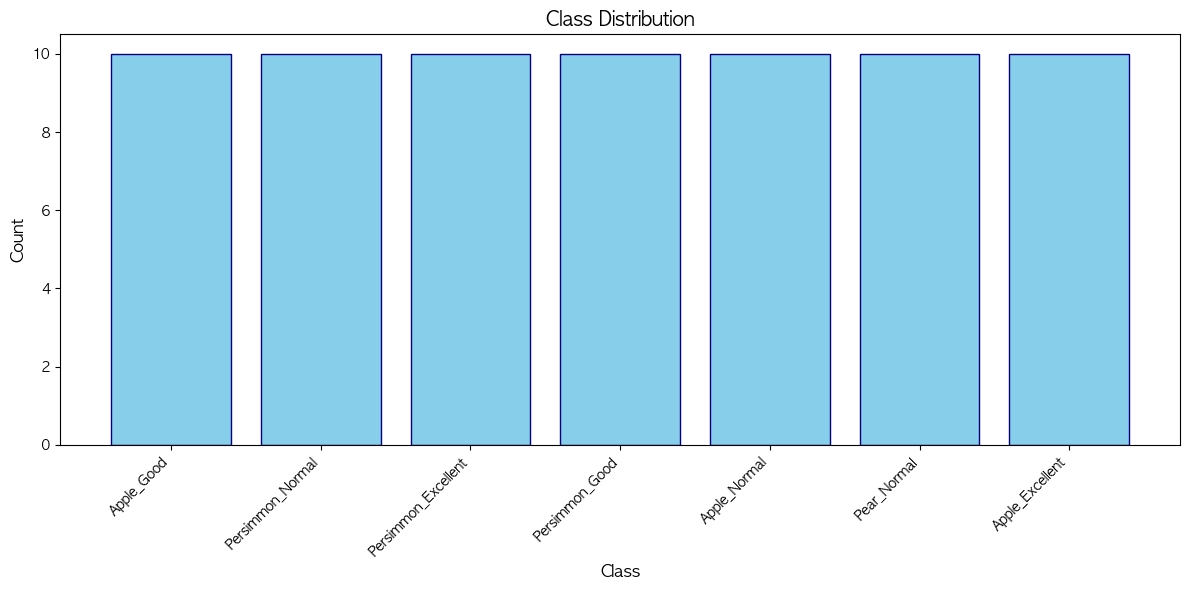

Train: 42개 (60.0%)
Val: 14개 (20.0%)
Test: 14개 (20.0%)
YOLO 포맷 데이터셋 생성 중...
✅ TRAIN: 42개
✅ VAL: 14개
✅ TEST: 14개
✅ YAML 파일 생성: ../data/processed/yolo/fruit_quality.yaml

# YOLOv5 과일 품질 등급 분류

path: ../data/processed/yolo
train: images/train
val: images/val
test: images/test

nc: 9

names:
  0: 사과_특상
  1: 사과_상
  2: 사과_중
  3: 배_특상
  4: 배_상
  5: 배_중
  6: 감_특상
  7: 감_상
  8: 감_중

YOLOv5m 학습 시작
train: weights=yolov5m.pt, cfg=, data=../data/processed/yolo/fruit_quality.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../data/processed/yolo/runs, name=fruit_quality_yolov5m, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, loc

NameError: name 'df' is not defined

In [2]:
# ============================================================================
# YOLOv5m 과일 품질 등급 분류 프로젝트
# ============================================================================
# 과일 종류: 사과, 배, 감
# 품질 등급: 특상, 상, 중
# 총 9개 클래스 분류
# ============================================================================

# %% [markdown]
# # 1. 환경 설정

# %%
import os
import json
import shutil
from pathlib import Path
from PIL import Image
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd

# 한글 폰트 설정 (OS별 자동 감지)
import platform
import matplotlib.font_manager as fm

system = platform.system()

# 사용 가능한 한글 폰트 찾기
available_fonts = [f.name for f in fm.fontManager.ttflist]
korean_fonts = ['AppleGothic', 'Malgun Gothic', 'NanumGothic', 'NanumBarunGothic', 'DejaVu Sans']

selected_font = None
for font in korean_fonts:
    if font in available_fonts:
        selected_font = font
        break

if selected_font:
    matplotlib.rcParams['font.family'] = selected_font
    print(f"✅ 선택된 폰트: {selected_font}")
else:
    print("⚠️  한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    # 그래프에 한글 대신 영문 사용
    matplotlib.rcParams['font.family'] = 'DejaVu Sans'

matplotlib.rcParams['axes.unicode_minus'] = False

# 경로 설정 - ⚠️ 실제 경로로 수정 필요
# PROJECT_ROOT = Path.cwd().parent  # 현재 디렉토리의 상위 폴더
PROJECT_ROOT = Path('../')  # 실제 경로로 수정 필요
RAW_DATA = PROJECT_ROOT / 'data' / 'raw'
PROCESSED_DATA = PROJECT_ROOT / 'data' / 'processed' / 'yolo'
YOLOV5_ROOT = PROJECT_ROOT / 'model' / 'yolov5'

# 디렉토리 생성
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("YOLOv5m 과일 품질 등급 분류 프로젝트")
print("=" * 80)
print(f"프로젝트 루트: {PROJECT_ROOT}")
print(f"원본 데이터: {RAW_DATA}")
print(f"처리된 데이터: {PROCESSED_DATA}")
print(f"YOLOv5 경로: {YOLOV5_ROOT}")


# %% [markdown]
# # 2. 클래스 정의

# %%
# 9개 클래스 정의
CLASS_NAMES = [
    '사과_특상', '사과_상', '사과_중',
    '배_특상', '배_상', '배_중',
    '감_특상', '감_상', '감_중'
]

# 영문 클래스명 (그래프용)
CLASS_NAMES_EN = [
    'Apple_Excellent', 'Apple_Good', 'Apple_Normal',
    'Pear_Excellent', 'Pear_Good', 'Pear_Normal',
    'Persimmon_Excellent', 'Persimmon_Good', 'Persimmon_Normal'
]

# 과일 종류 매핑
FRUIT_MAP = {
    '사과': 0,
    '배': 1,
    '감': 2
}

# 품질 등급 매핑
QUALITY_MAP = {
    '특': 0,    # 특 → 특상
    '상': 1,    # 상
    '중': 2,    # 중
    '보통': 2   # 보통 → 중 (동일하게 처리)
}

def get_class_id(cate1, cate3):
    """과일 종류와 품질을 조합하여 클래스 ID 반환"""
    fruit_id = FRUIT_MAP.get(cate1, -1)
    quality_id = QUALITY_MAP.get(cate3, -1)
    
    if fruit_id == -1 or quality_id == -1:
        return -1
    
    return fruit_id * 3 + quality_id

# 클래스 출력
for i, name in enumerate(CLASS_NAMES):
    print(f"클래스 {i}: {name}")


# %% [markdown]
# # 3. 데이터 전처리 함수

# %%
def convert_bbox_to_yolo(bbox, img_width, img_height):
    """바운딩 박스를 YOLO 포맷으로 변환"""
    xmin = bbox['xmin']
    ymin = bbox['ymin']
    xmax = bbox['xmax']
    ymax = bbox['ymax']
    
    x_center = (xmin + xmax) / 2.0 / img_width
    y_center = (ymin + ymax) / 2.0 / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    
    return x_center, y_center, width, height


def process_json_file(json_path):
    """JSON 파일 처리"""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        cate1 = data.get('cate1', '')
        cate3 = data.get('cate3', '')
        img_width = data.get('img_width', 1000)
        img_height = data.get('img_height', 1000)
        bbox = data.get('bndbox', {})
        
        class_id = get_class_id(cate1, cate3)
        
        if class_id == -1:
            return None, f"알 수 없는 클래스 (cate1={cate1}, cate3={cate3})"
        
        x_center, y_center, width, height = convert_bbox_to_yolo(bbox, img_width, img_height)
        
        return {
            'class_id': class_id,
            'class_name': CLASS_NAMES[class_id],
            'bbox': (x_center, y_center, width, height),
            'cate1': cate1,
            'cate3': cate3
        }, None
    
    except Exception as e:
        return None, f"파일 처리 오류: {str(e)}"


# %% [markdown]
# # 4. 데이터 로드 및 전처리

# %%
print("=" * 80)
print("데이터 전처리 시작")
print("=" * 80)

json_dir = RAW_DATA / 'json_labels'
image_dir = RAW_DATA / 'images'

json_files = list(json_dir.glob('*.json'))
print(f"총 JSON 파일 수: {len(json_files)}")

processed_data = []
error_files = []

for json_file in json_files:
    result, error_msg = process_json_file(json_file)
    
    if result is not None:
        image_name = json_file.stem + '.png'
        image_path = image_dir / image_name
        
        if image_path.exists():
            result['image_path'] = image_path
            result['json_path'] = json_file
            processed_data.append(result)
        else:
            error_files.append(f"{json_file.name} - 이미지 없음: {image_name}")
    else:
        error_files.append(f"{json_file.name} - {error_msg}")

print(f"✅ 성공: {len(processed_data)}개")
print(f"❌ 오류: {len(error_files)}개")

# 오류 파일 상세 출력
if error_files:
    print("\n⚠️  오류 파일 목록 (처음 20개):")
    for i, error in enumerate(error_files[:20], 1):
        print(f"  {i}. {error}")


# %% [markdown]
# # 5. 데이터 분석

# %%
# 클래스별 분포
class_counts = defaultdict(int)
for item in processed_data:
    class_counts[item['class_name']] += 1

print("\n클래스별 데이터 분포:")
for class_name in CLASS_NAMES:
    count = class_counts.get(class_name, 0)
    print(f"  {class_name}: {count}개")

# 시각화 (영문 라벨 사용)
plt.figure(figsize=(12, 6))
classes_en = [CLASS_NAMES_EN[CLASS_NAMES.index(c)] if c in CLASS_NAMES else c for c in class_counts.keys()]
counts = list(class_counts.values())

plt.bar(range(len(classes_en)), counts, color='skyblue', edgecolor='navy')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution', fontsize=14)
plt.xticks(range(len(classes_en)), classes_en, rotation=45, ha='right')
plt.tight_layout()
plt.show()


# %% [markdown]
# # 6. 데이터셋 분할

# %%
random.seed(42)
random.shuffle(processed_data)

total = len(processed_data)
train_size = int(total * 0.6)
val_size = int(total * 0.2)

train_data = processed_data[:train_size]
val_data = processed_data[train_size:train_size + val_size]
test_data = processed_data[train_size + val_size:]

print(f"Train: {len(train_data)}개 ({len(train_data)/total*100:.1f}%)")
print(f"Val: {len(val_data)}개 ({len(val_data)/total*100:.1f}%)")
print(f"Test: {len(test_data)}개 ({len(test_data)/total*100:.1f}%)")


# %% [markdown]
# # 7. YOLO 포맷 데이터셋 생성

# %%
def create_yolo_dataset(data_list, split_name):
    """YOLO 포맷 데이터셋 생성"""
    image_dir = PROCESSED_DATA / 'images' / split_name
    label_dir = PROCESSED_DATA / 'labels' / split_name
    
    image_dir.mkdir(parents=True, exist_ok=True)
    label_dir.mkdir(parents=True, exist_ok=True)
    
    for item in data_list:
        # 이미지 복사
        src_image = item['image_path']
        dst_image = image_dir / src_image.name
        shutil.copy2(src_image, dst_image)
        
        # 라벨 생성
        label_file = label_dir / (src_image.stem + '.txt')
        with open(label_file, 'w') as f:
            class_id = item['class_id']
            x, y, w, h = item['bbox']
            f.write(f"{class_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
    
    print(f"✅ {split_name.upper()}: {len(data_list)}개")

print("YOLO 포맷 데이터셋 생성 중...")
create_yolo_dataset(train_data, 'train')
create_yolo_dataset(val_data, 'val')
create_yolo_dataset(test_data, 'test')


# %% [markdown]
# # 8. YAML 설정 파일 생성

# %%
yaml_content = f"""# YOLOv5 과일 품질 등급 분류

path: {PROCESSED_DATA.as_posix()}
train: images/train
val: images/val
test: images/test

nc: 9

names:
  0: 사과_특상
  1: 사과_상
  2: 사과_중
  3: 배_특상
  4: 배_상
  5: 배_중
  6: 감_특상
  7: 감_상
  8: 감_중
"""

yaml_path = PROCESSED_DATA / 'fruit_quality.yaml'
with open(yaml_path, 'w', encoding='utf-8') as f:
    f.write(yaml_content)

print(f"✅ YAML 파일 생성: {yaml_path}")
print("\n" + yaml_content)


# %% [markdown]
# # 9. YOLOv5m 학습 실행

# %%
# YOLOv5 디렉토리로 이동하여 학습 실행
print("=" * 80)
print("YOLOv5m 학습 시작")
print("=" * 80)

# 학습 명령어 실행
!cd {YOLOV5_ROOT} && python train.py \
    --img 640 \
    --batch 4 \
    --epochs 1 \
    --data {yaml_path} \
    --weights yolov5m.pt \
    --project {PROCESSED_DATA}/runs \
    --name fruit_quality_yolov5m \
    --exist-ok \
    --cache


# %% [markdown]
# # 10. 학습 결과 시각화

# %%
RESULTS_DIR = PROCESSED_DATA / 'runs' / 'fruit_quality_yolov5m'

# 학습 완료 여부 확인
if not RESULTS_DIR.exists():
    print("❌ 학습 결과 폴더가 없습니다!")
    print(f"   경로: {RESULTS_DIR}")
    print("\n⚠️  먼저 '# 9. YOLOv5m 학습 실행' 셀을 실행해주세요!")
else:
    # results.csv 확인
    results_csv = RESULTS_DIR / 'results.csv'
    
    if not results_csv.exists():
        print("❌ results.csv 파일을 찾을 수 없습니다!")
        print(f"   경로: {results_csv}")
        print("\n📁 학습 폴더 내용:")
        for item in RESULTS_DIR.iterdir():
            print(f"   - {item.name}")
        print("\n⚠️  학습이 완료되지 않았거나, 경로가 잘못되었을 수 있습니다.")
    else:
        # results.csv 읽기
        df = pd.read_csv(results_csv, skipinitialspace=True)
        df.columns = df.columns.str.strip()
        
        print("✅ 학습 결과 요약:")
        print(f"총 에포크: {len(df)}")
        print(f"최종 mAP@0.5: {df['metrics/mAP_0.5'].iloc[-1]:.4f}")
        print(f"최종 mAP@0.5:0.95: {df['metrics/mAP_0.5:0.95'].iloc[-1]:.4f}")
        
        # 학습 곡선 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Train Loss
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Box Loss')
        axes[0, 0].plot(df['epoch'], df['train/obj_loss'], label='Obj Loss')
        axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Cls Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Training Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Val Loss
        axes[0, 1].plot(df['epoch'], df['val/box_loss'], label='Box Loss')
        axes[0, 1].plot(df['epoch'], df['val/obj_loss'], label='Obj Loss')
        axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Cls Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].set_title('Validation Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Precision & Recall
        axes[1, 0].plot(df['epoch'], df['metrics/precision'], label='Precision')
        axes[1, 0].plot(df['epoch'], df['metrics/recall'], label='Recall')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_title('Precision & Recall')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # mAP
        axes[1, 1].plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5')
        axes[1, 1].plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('mAP')
        axes[1, 1].set_title('Mean Average Precision')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'training_curves.png', dpi=300)
        plt.show()
        
        print(f"\n✅ 학습 곡선 저장: {RESULTS_DIR / 'training_curves.png'}")
        
        # Confusion Matrix
        cm_path = RESULTS_DIR / 'confusion_matrix.png'
        if cm_path.exists():
            img = Image.open(cm_path)
            plt.figure(figsize=(12, 10))
            plt.imshow(img)
            plt.axis('off')
            plt.title('Confusion Matrix')
            plt.show()
        else:
            print("\n⚠️  Confusion Matrix 이미지를 찾을 수 없습니다.")


# %% [markdown]
# # 11. 테스트 데이터 평가

# %%
BEST_WEIGHTS = RESULTS_DIR / 'weights' / 'best.pt'

!cd {YOLOV5_ROOT} && python val.py \
    --weights {BEST_WEIGHTS} \
    --data {yaml_path} \
    --img 640 \
    --batch 4 \
    --task test \
    --project {PROCESSED_DATA}/runs \
    --name test_results \
    --exist-ok


# %% [markdown]
# # 12. 추론 (새 이미지 예측)

# %%
TEST_IMAGES = PROCESSED_DATA / 'images' / 'test'

!cd {YOLOV5_ROOT} && python detect.py \
    --weights {BEST_WEIGHTS} \
    --source {TEST_IMAGES} \
    --img 640 \
    --conf 0.25 \
    --project {PROCESSED_DATA}/runs \
    --name predictions \
    --exist-ok \
    --save-txt \
    --save-conf


# %% [markdown]
# # 13. 추론 결과 분석

# %%
PREDICTIONS_DIR = PROCESSED_DATA / 'runs' / 'predictions'
labels_dir = PREDICTIONS_DIR / 'labels'

predictions = []

if labels_dir.exists():
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 6:
                    class_id = int(parts[0])
                    conf = float(parts[5])
                    predictions.append({
                        'class_id': class_id,
                        'class_name': CLASS_NAMES[class_id],
                        'confidence': conf
                    })

if predictions:
    df_pred = pd.DataFrame(predictions)
    
    print(f"총 예측 개수: {len(predictions)}")
    print(f"평균 신뢰도: {df_pred['confidence'].mean():.4f}")
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 클래스별 분포
    class_dist = df_pred['class_name'].value_counts()
    class_dist.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('클래스별 예측 분포')
    axes[0].set_xlabel('클래스')
    axes[0].set_ylabel('개수')
    
    # 신뢰도 분포
    axes[1].hist(df_pred['confidence'], bins=20, color='lightgreen')
    axes[1].set_title('신뢰도 분포')
    axes[1].set_xlabel('신뢰도')
    axes[1].set_ylabel('빈도')
    
    plt.tight_layout()
    plt.show()


# %% [markdown]
# # 14. 프로젝트 완료 요약

# %%
print("=" * 80)
print("프로젝트 완료!")
print("=" * 80)
print(f"""
✅ 완료된 작업:
1. 데이터 전처리: {len(processed_data)}개
2. Train/Val/Test 분할: {len(train_data)}/{len(val_data)}/{len(test_data)}
3. YOLOv5m 학습 완료
4. 최종 mAP@0.5: {df['metrics/mAP_0.5'].iloc[-1]:.4f}

📂 주요 결과물:
- 모델: {BEST_WEIGHTS}
- 학습 곡선: {RESULTS_DIR}/training_curves.png
- Confusion Matrix: {RESULTS_DIR}/confusion_matrix.png

🎯 다음 단계:
- EfficientDet 모델과 성능 비교
- 4500개 전체 데이터로 재학습
""")